In [1]:
# Import all system modules
import os
import sys
import time

# Import all scientific modules
import numpy as np
from pytf import FilterBank
from mspacman import PhaseAmplitudeCoupling
from pactools import Comodulogram, REFERENCES
import pacpy
import mne

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

/Users/davidlu/.virtualenvs/py-phd/lib/python3.6/site-packages/pactools-0.2.dev0-py3.6.egg/pactools/dar_model/stable_dar.py:62: DeprecationWarning: invalid escape sequence \;
/Users/davidlu/.virtualenvs/py-phd/lib/python3.6/site-packages/pactools-0.2.dev0-py3.6.egg/pactools/dar_model/stable_dar.py:62: DeprecationWarning: invalid escape sequence \;
/Users/davidlu/.virtualenvs/py-phd/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<a id=load_data></a>
# Generate Data

In [2]:
depth = '07661'
data_path = os.getcwd()
fname = os.path.join(data_path, 'data', 'mer_{}_raw.fif'.format(depth))

obj_ = mne.io.read_raw_fif(fname, preload=True)
raw = obj_.get_data()

fs = int(obj_.info['sfreq'])
nch, nsamp = raw.shape

t = np.arange(nsamp) / fs
print(nch, nsamp)
print(t[0], t[-1])

t_seg = [4, 20]
tvec = t[fs*t_seg[0]:fs*t_seg[-1]]
t_start = 4

# Original data
dat = np.atleast_2d(raw[0,fs*t_seg[0]:fs*t_seg[-1]])

Opening raw data file /Users/davidlu/Developer/PhD Projects/notes_mspacman/data/mer_07661_raw.fif...
Isotrak not found
    Range : 0 ... 2600336 =      0.000 ...   108.347 secs
Ready.
Reading 0 ... 2600336  =      0.000 ...   108.347 secs...
1 2600337
0.0 108.34733333333334


## Generate Artifact

### Clipping signal

In [6]:
# Clip data
clip_amp = 400
clip = raw.copy()

clip[clip>=clip_amp] = clip_amp
clip[clip<=-clip_amp] = -clip_amp

dat_clip = np.atleast_2d(clip[0,fs*t_seg[0]:fs*t_seg[-1]])

Processing Segments of signal: 
--------------------------------------------------
  Window Size: 4.0 [s]
  Step Size:   0.25 [s]
(49, 96000) (49,) (1, 384000)


In [7]:
window_size = 4     # in seconds
Nwinsize    = int((fs) * window_size)
stride      = int((fs) * .25)

print('Processing Segments of signal: ')
print('-'*50)
print('  Window Size: {} [s]'.format(Nwinsize/fs))
print('  Step Size:   {} [s]'.format(stride/fs))

dat_win = []
dat_win_clip = []
segments = []
for ix, i in enumerate(range(0, int((fs)*(t_seg[-1]-t_start)), stride)):
    i += (fs*t_seg[0])
    if i+Nwinsize <= (fs)*t_seg[-1]:
        dat_win += [raw[0,i:i+Nwinsize]]
        dat_win_clip+= [clip[0,i:i+Nwinsize]]
        segments  += [(i+Nwinsize/2)/(fs)]
dat_win = np.asarray(dat_win)
dat_win_clip = np.asarray(dat_win_clip)
segments = np.asarray(segments)
print(dat_win.shape, segments.shape, dat.shape)

Processing Segments of signal: 
--------------------------------------------------
  Window Size: 4.0 [s]
  Step Size:   0.25 [s]
(49, 96000) (49,) (1, 384000)


The full duration of the signal is 108.0 seconds.


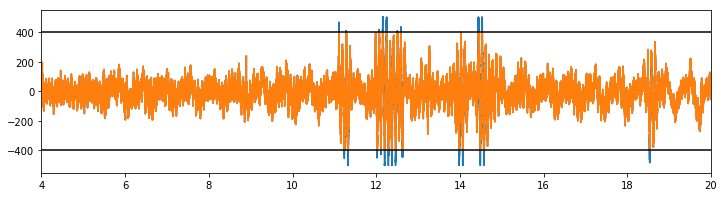

In [13]:
plt.figure(figsize=(12, 3))

plt.plot(tvec, dat.T)
plt.plot(tvec, dat_clip.T)

plt.axhline(y=clip_amp, c='k')
plt.axhline(y=-clip_amp, c='k')
plt.xlim(t_seg)

print("The full duration of the signal is {} seconds.".format(np.round(t[-1])))

# Processing Comodulograms

In [14]:
# Initialize variables
comod = {
    'mspacman': [],
    'pactools': [],
    'pacpy': []
}

comod_clip = {
    'mspacman': [],
    'pactools': [],
    'pacpy': []
}

mi_seg = {
    'mspacman': [],
    'pactools': [],
    'pacpy': []
}

mi_seg_clip = {
    'mspacman': [],
    'pactools': [],
    'pacpy': []
}

# Filter bank parameters
dp = 3
da = 30
fpsize = 40
fasize = 60

p_range = (6, 50)
a_range = (60, 500)

fp = np.arange(*p_range, np.diff(p_range)/fpsize, dtype=int)
fa = np.arange(*a_range, np.diff(a_range)/fasize, dtype=int)

f_lo = np.asarray([(p-dp, p+dp) for p in fp])
f_hi = np.asarray([(a-da, a+da) for a in fa])

### MSPACMan

In [6]:
#################################
# Process Comodulogram
#################################
pac_ = PhaseAmplitudeCoupling(nch=dat.shape[0], nsamp=dat.shape[-1], binsize=2**15, freq_phase=f_lo, freq_amp=f_hi,\
                               sample_rate=fs, nprocs=3, pac='mi', mprocs=True)

comod['mspacman'] = pac_.comodulogram(dat)
comod_clip['mspacman'] = pac_.comodulogram(dat_clip)
pac_.kill()

#################################
# Process segments of data
#################################
pac_ = PhaseAmplitudeCoupling(nch=dat_win.shape[0], nsamp=dat_win.shape[-1], binsize=2**15, freq_phase=[(10, 30)], freq_amp=[(60, 180)],\
                              sample_rate=fs, mprocs=False, nprocs=1, pac='mi')

mi_seg['mspacman'] = pac_.comodulogram(dat_win)[:,0,0]
mi_seg_clip['mspacman'] = pac_.comodulogram(dat_win_clip)[:,0,0]

/Users/davidlu/.virtualenvs/py-phd/lib/python3.6/site-packages/pytf-0.1-py3.6.egg/pytf/filter/filterbank.py:338: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/Users/davidlu/.virtualenvs/py-phd/lib/python3.6/site-packages/mspacman-0.1-py3.6.egg/mspacman/utilities/parallel.py:35: UserWarning: The multiprocessing is disabled! To enable multiprocessing, specify 'ins_shape' and 'out_shape' for preallocating shared memory.


### PACTools

In [15]:
#################################
# Process Comodulogram
#################################
t0 = time.time()
obj = Comodulogram(fs=fs, low_fq_range=fp, low_fq_width=dp,
                    high_fq_range=fa, high_fq_width=da,
                    method='tort', progress_bar=False)

obj.fit(dat[0,:])
comod['pactools'] = obj.comod_
t1 = time.time()
obj.fit(dat_clip[0,:])
comod_clip['pactools'] = obj.comod_
t2 = time.time()
print("Processing Time: {} [s] and {} [s]".format(t1-t0, t2-t1))

#################################
# Process segments of data
#################################
from pactools.bandpass_filter import multiple_band_pass
from pactools.comodulogram import _comodulogram

mi_seg['pactools'] = []
mi_seg_clip['pactools'] = []
for tmp in dat_win:
    filtered_lo = multiple_band_pass(tmp, fs, 20, 20)
    filtered_hi = multiple_band_pass(tmp, fs, 120, 60)
    mi_seg['pactools'] += [_comodulogram(obj, filtered_lo, filtered_hi, None, None).flatten()]

mi_seg['pactools'] = np.asarray(mi_seg['pactools']).flatten()

for tmp in dat_win_clip:
    filtered_lo_ = multiple_band_pass(tmp, fs, 20, 20)
    filtered_hi_ = multiple_band_pass(tmp, fs, 120, 60)
    mi_seg_clip['pactools'] += [_comodulogram(obj, filtered_lo_, filtered_hi_, None, None).flatten()]

mi_seg_clip['pactools'] = np.asarray(mi_seg_clip['pactools']).flatten()

Processing Time: 34.34331393241882 [s] and 35.91286015510559 [s]


### PACPy

In [16]:
#################################
# Process Comodulogram
#################################
comod['pacpy'] = pacpy.pac.comodulogram(dat[0,:], dat[0,:], \
                                    p_range, a_range, dp, da, fs=fs, w_lo=3, w_hi=3, pac_method='mi_tort')

comod_clip['pacpy'] = pacpy.pac.comodulogram(dat_clip[0,:], dat_clip[0,:], \
                                    p_range, a_range, dp, da, fs=fs, w_lo=3, w_hi=3, pac_method='mi_tort')

#################################
# Process segments of data
#################################
mi_seg['pacpy'] = np.array([pacpy.pac.mi_tort(tmp,tmp, (10,30), (60,180)) for tmp in dat_win])
mi_seg_clip['pacpy'] = np.array([pacpy.pac.mi_tort(tmp,tmp, (10,30), (60,180)) for tmp in dat_win_clip])

NameError: name 'comod' is not defined

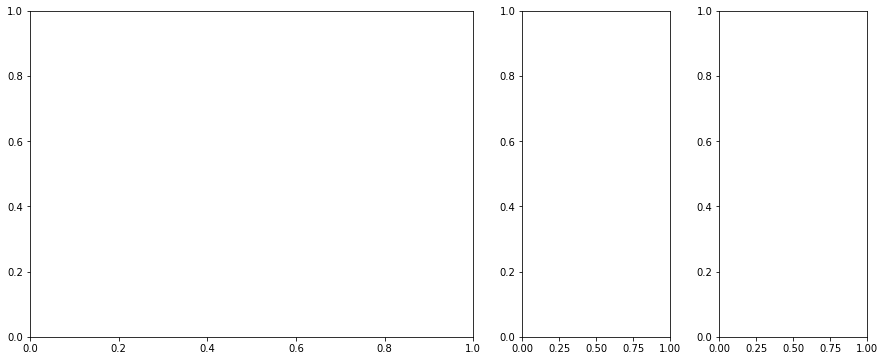

In [4]:
gs = GridSpec(1, 3, width_ratios=[3,1,1])

plt.figure(figsize=(15, 6))
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 0])
ax2.imshow(comod['mspacman'][0,:,:].T, origin='lower', interpolation=None,
                 vmin=comod['mspacman'].min(), vmax=comod['mspacman'].max(),
                 extent=[fp[0],fp[-1],fa[0],fa[-1]], aspect='auto', cmap='gray')

ax3.imshow(comod_clip['mspacman'][0,:,:].T, origin='lower', interpolation=None,
                 vmin=comod_clip['mspacman'].min(), vmax=comod_clip['mspacman'].max(),
                 extent=[fp[0],fp[-1],fa[0],fa[-1]], aspect='auto', cmap='gray')

ax4.plot(segments, mi_seg['mspacman'], '.-')
ax4.plot(segments, mi_seg_clip['mspacman'], '.-')
ax4.set_xlim([4, 20])
ax1.set_xlim([4, 20])

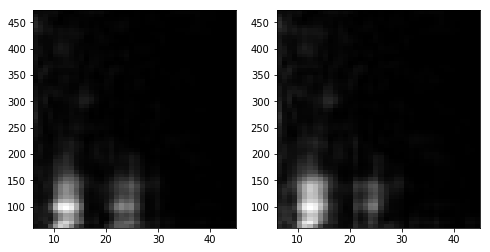

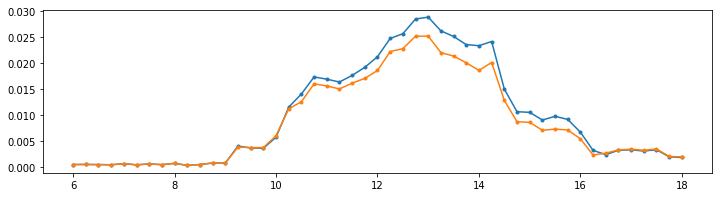

In [16]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.imshow(comod['pactools'].T, origin='lower', interpolation=None,
                 vmin=comod['pactools'].min(), vmax=comod['pactools'].max(),
                 extent=[fp[0],fp[-1],fa[0],fa[-1]], aspect='auto', cmap='gray')
plt.subplot(122)
plt.imshow(comod_clip['pactools'].T, origin='lower', interpolation=None,
                 vmin=comod_clip['pactools'].min(), vmax=comod_clip['pactools'].max(),
                 extent=[fp[0],fp[-1],fa[0],fa[-1]], aspect='auto', cmap='gray')
plt.figure(figsize=(12, 3))
plt.plot(segments, mi_seg['pactools'], '.-')
plt.plot(segments, mi_seg_clip['pactools'], '.-')

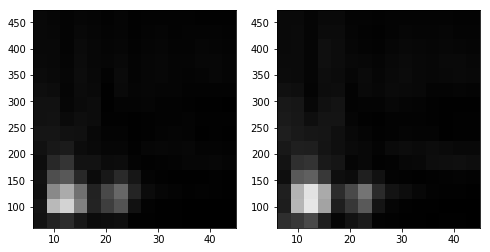

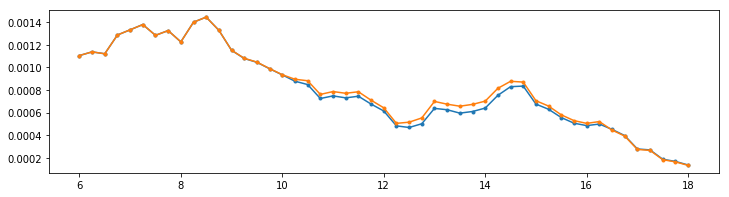

In [15]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.imshow(comod['pacpy'].T, origin='lower', interpolation=None,
                 vmin=comod['pactools'].min(), vmax=comod['pactools'].max(),
                 extent=[fp[0],fp[-1],fa[0],fa[-1]], aspect='auto', cmap='gray')
plt.subplot(122)
plt.imshow(comod_clip['pacpy'].T, origin='lower', interpolation=None,
                 vmin=comod_clip['pactools'].min(), vmax=comod_clip['pactools'].max(),
                 extent=[fp[0],fp[-1],fa[0],fa[-1]], aspect='auto', cmap='gray')

plt.figure(figsize=(12, 3))
plt.plot(segments, mi_seg['pacpy'], '.-')
plt.plot(segments, mi_seg_clip['pacpy'], '.-')